In [6]:
%load_ext autoreload
%autoreload 2

import plots
from experiments import IndependentNoiseOn2CoupledNetworks


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Effect of uncorrelated noise on coupled EI networks

Hypothesis
* in certain parameter regimes the EI networks synchronize while within synchronization decreases
* only a fraction of the neurons in a network spike in each cycle, we see a widened voltage distribution

Setup
* 2 coupled network case
* independent noise with varying strengths

Metrics & Visualization
* overlap in peak frequency in power spectrum indicates synchronization
* local and global order parameter quantify synchronization respectively
* optional: mean phase coherence

Run for different noise strenghts and plot PSD spectra of all runs.
A handful of parameter sets should suffice to get a first intuition. Afterwards we can do an exhaustive parameter exploration.

In [7]:
exp = IndependentNoiseOn2CoupledNetworks()

In [8]:
exp.clean()
exp.run()

1 of [0.2 0.5 0.8 1.1 1.4 1.7] Running parameter configuration: 0.2 ...
Initializing net ...
Initialization time: 0.703484296798706s
==== Running Network ... ====
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 4s
==== Network Run Finished ====
runtime: 15.4
2 of [0.2 0.5 0.8 1.1 1.4 1.7] Running parameter configuration: 0.5 ...
Initializing net ...
Initialization time: 0.8526382446289062s
==== Running Network ... ====
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 4s
==== Network Run Finished ====
runtime: 5.3
3 of [0.2 0.5 0.8 1.1 1.4 1.7] Running parameter configuration: 0.8 ...
Initializing net ...
Initialization time: 0.6518330574035645s
==== Running Network ... ====
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 4s
==== Network Run Finished ====
runtime: 4.9
4 of [0.2 0.5 0.8 1.1 1.4 1.7] Running parameter configuration: 1.0999999999999999 ...
Initializing net ...
Initialization time

WARNING    Note that the synaptic pathway 'synapses_10_pre' will run on the clock of the group 'neurongroup_3' using a dt of 5e-05. Either the Synapses object 'synapses_10' or the target 'neurongroup_2' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 5e-05. If in doubt, try to ensure that 'neurongroup_3', 'synapses_10', and 'neurongroup_2' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]
WARNING    Note that the synaptic pathway 'synapses_11_pre' will run on the clock of the group 'neurongroup_3' using a dt of 5e-05. Either the Synapses object 'synapses_11' or the target 'neurongroup_3' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 5e-05. If in doubt, try to ensure that 'neurongroup_3', 'synapses_11', and 'neurongroup_3' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]
WARNING    Note 

In [9]:
models = exp.load()
print(len(models))

6


Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...


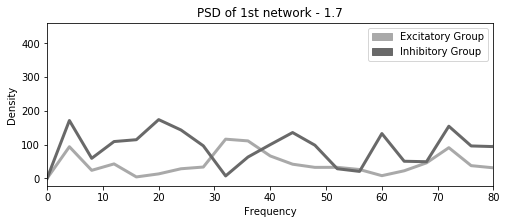

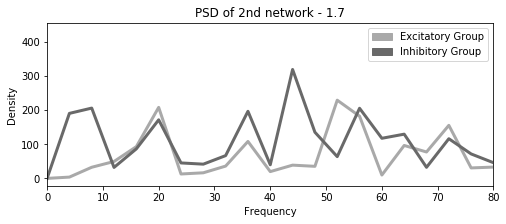

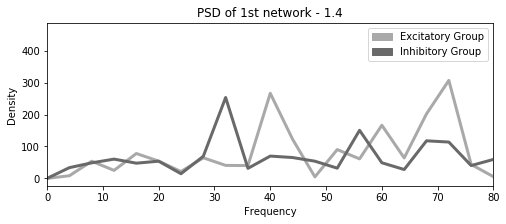

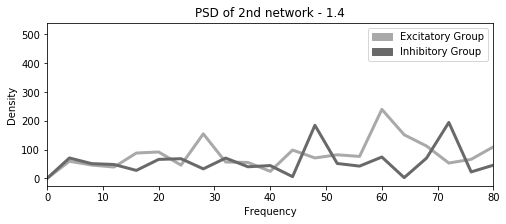

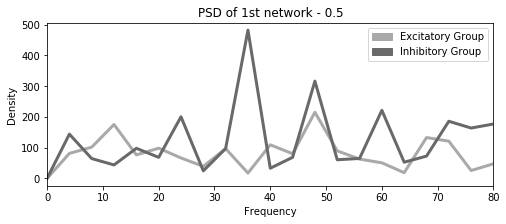

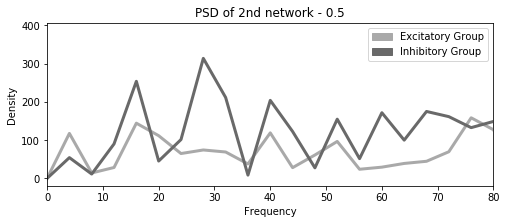

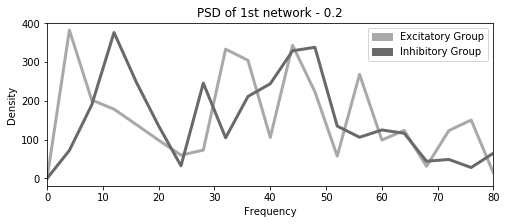

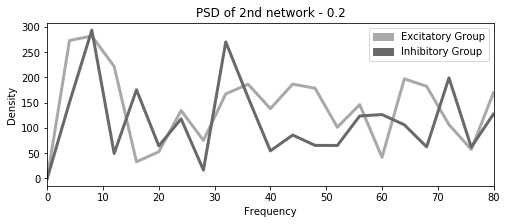

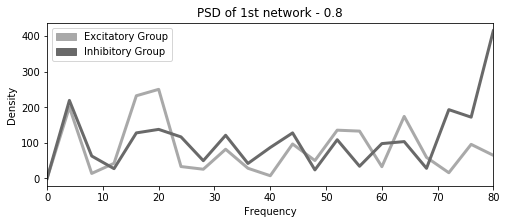

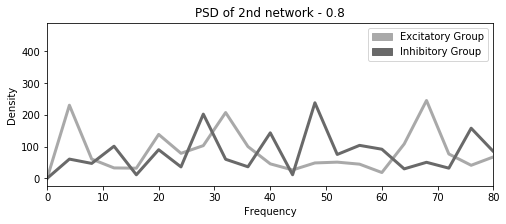

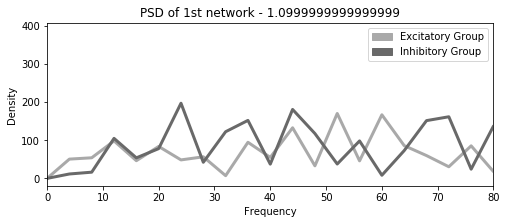

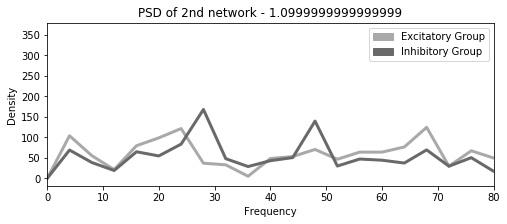

In [10]:
# TODOs:
# * Improve PSD plotting
# * calculate global and local order parameter for each run
# * compare coupled state with uncoupled state, uncoupled state acts as control group
# * with current EI network parameters we get a very scattered power spectrum, adjust parameters so that we get 1-3 main peaks in gamma band only.

for model in models:
    strength = model["params"]["poisson_strengths"][0]
    plots.psd(model, title=f"PSD of 1st network - {strength}", population=1)
    plots.psd(model, title=f"PSD of 2nd network - {strength}", population=2)
